In [1]:
from __future__ import print_function
import tensorflow
import datetime
import keras
import pandas as pd
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from PIL import Image
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from scipy import spatial
%matplotlib inline


Using TensorFlow backend.
/home/u6975/.conda/envs/tensorflow-36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [42]:
################## set up some variables #################
# directory of your project
dir_path = '/home/u6975/'
im = []

# set some parameters
batch_size = 300
num_classes = 7
epochs = 5

# set some more parameters
img_rows, img_cols = 50, 50
filters = 32
pool_size = 2
kernel_size = 5
img_channels = 1

#used to help some of the timing functions
now = datetime.datetime.now


In [3]:
# get the path to all pictures in im list. Comment out cuz we got it
#def get_image_paths(path, im):
#    listing = os.listdir(path)
#    count = 0
#    for item in listing:

#        if item == '.DS_Store':
#            continue
#        else:
#            if '.jpg' in listing[0]:
#                if count == 0:
#                    im += [path + '/' + i for i in listing]
#                    count += 1
#            else:         
#                get_image_paths(path + '/' + item, im)

#get_image_paths(dir_path, im)

In [5]:
# create resize_images. Comment out because we got it
#for path in imlist:
#    temp = Image.open(path)
#    temp = temp.resize((img_rows,img_cols))
#    temp = temp.convert('L')
#    fileName = path.split('/')[-1]
#    tempArr = fileName.split('-')
#    temp.save('/home/u6975/resize_img/' + tempArr[0] + '-' + tempArr[1], "JPEG")

In [31]:
################ function to train the model ##################
def train_model(model, x_train, x_test, y_train, y_test, num_classes, epochs, featureName):
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols,1)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    # checkpoint
    if featureName == 'Category':
        filepath= dir_path + "models/" + featureName + ".best.hdf5"
    elif featureName == 'Gender':
        filepath= dir_path + "models/" + featureName + ".best.hdf5"
    elif featureName == 'SubCategory':
        filepath= dir_path + "models/" + featureName + ".best.hdf5"
    elif featureName == 'HeelHeight':
        filepath= dir_path + "models/" + featureName + ".best.hdf5"
        
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks_list,
              verbose=1,
              validation_data=(x_test, y_test))
    

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [32]:
def get_model(num_classes):
    ################ feature reducing layer ##############
    feature_layers = [
        Conv2D(filters, kernel_size,
               padding='valid',
               input_shape=(img_rows, img_cols,1)),
        Activation('relu'),
        Conv2D(filters, kernel_size),
        Activation('relu'),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.25),
        Flatten(),
    ]

    ############ classification layer ############
    classification_layers = [
        Dense(128),
        Activation('relu'),
        Dropout(0.5),
        Dense(num_classes),
        Activation('softmax')
    ]

    # We create our model by combining the two sets of layers as follows
    model = Sequential(feature_layers + classification_layers)
    return model

In [33]:
################# Needed function ##############
# filter df to the needed cols and modify the new df CID col
def get_df(filterString):
    df = pd.read_csv('meta-data-bin.csv')
    df1 = df.filter(regex='CID').join(df.filter(regex=filterString))

    for x in range(50025):
        df1.iloc[[x],[0]] = dir_path + 'resize_img/' + df1.iloc[[x],[0]] + '.jpg'
    return df1

# join table and drop NaN
def join_drop(df, feature):
    df1 = pd.read_csv('meta-data.csv')
    df1 = df1.drop('CID', 1)
    df2 = df1.join(df)
    df2 = df2.dropna(subset=[feature])
    df2 = df2.filter(regex='CID').join(df.filter(regex=feature))
    df2 = df2[~df2['CID'].isin([dir_path + 'resize_img/8029595-574.jpg'])]
    return df2

# make a matrix for flatten img
def make_matrix(df):    
    imlist1 = df['CID'].values.tolist()
    immatrix = np.array([np.array(Image.open(im2)).flatten() for im2 in imlist1])
    immatrix.astype(float)
    return immatrix

# make labels list
def make_label(df):
    temp = len(df.index)
    label1 = np.ones((temp,),dtype = int)
    for x in range(temp):
        for t in range(df.shape[1]):
            if df.get_value(x, t, takeable=True) == 1:
                label1[x] = t - 1
                break
    return label1

In [11]:
############ This part is for Gender ###############
# Men
# Women
# Boy
# Girl

# init some variables
feature = 'Gender'
num_classes = 4
epochs = 20

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

x_train shape: (40014, 50, 50, 1)
40014 train samples
10004 test samples
Train on 40014 samples, validate on 10004 samples
Epoch 1/20
40014/40014 [==============================] - 49s - loss: 0.9021 - acc: 0.6308 - val_loss: 0.7683 - val_acc: 0.6843
Epoch 2/20
40014/40014 [==============================] - 48s - loss: 0.7634 - acc: 0.6902 - val_loss: 0.7118 - val_acc: 0.7081
Epoch 3/20
40014/40014 [==============================] - 49s - loss: 0.7133 - acc: 0.7108 - val_loss: 0.6686 - val_acc: 0.7268
Epoch 4/20
40014/40014 [==============================] - 49s - loss: 0.6718 - acc: 0.7272 - val_loss: 0.6444 - val_acc: 0.7426
Epoch 5/20
40014/40014 [==============================] - 49s - loss: 0.6476 - acc: 0.7363 - val_loss: 0.6240 - val_acc: 0.7455
Epoch 6/20
40014/40014 [==============================] - 49s - loss: 0.6190 - acc: 0.7489 - val_loss: 0.6047 - val_acc: 0.7538
Epoch 7/20
40014/40014 [==============================] - 48s - loss: 0.6007 - acc: 0.7570 - val_loss: 0.6029

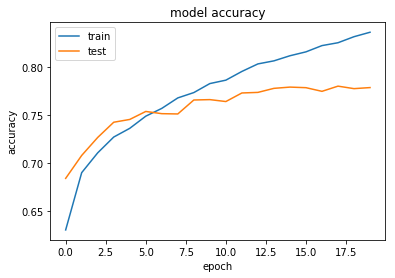

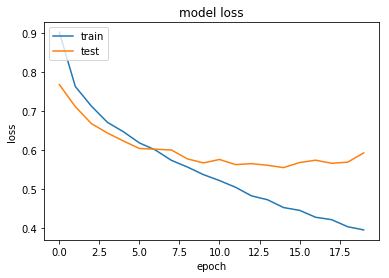

Test score: 0.593387214161
Test accuracy: 0.778588564527


In [12]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

In [34]:
############ This part is for SubCategory ###############
# Oxfords
# Mid.Calf
# Heel
# Ankle
# Boot
# Loafers
# Slipper.Flats
# Boat.Shoes
# Flat
# Clogs.and.Mules
# Flats
# Sneakers.and.Athletic.Shoes
# Slipper.Heels
# Heels
# Athletic
# Prewalker
# Knee.High
# Prewalker.Boots
# Crib.Shoes
# Firstwalker
# Over.the.Knee

# init some variables
feature = 'SubCategory'
num_classes = 21
epochs = 20

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

x_train shape: (40019, 50, 50, 1)
40019 train samples
10005 test samples
Train on 40019 samples, validate on 10005 samples
Epoch 1/20
40019/40019 [==============================] - 53s - loss: 1.5722 - acc: 0.5219 - val_loss: 1.1003 - val_acc: 0.6677
Epoch 2/20
40019/40019 [==============================] - 52s - loss: 1.0255 - acc: 0.6892 - val_loss: 0.8213 - val_acc: 0.7411
Epoch 3/20
40019/40019 [==============================] - 52s - loss: 0.8852 - acc: 0.7224 - val_loss: 0.7604 - val_acc: 0.7512
Epoch 4/20
40019/40019 [==============================] - 51s - loss: 0.8057 - acc: 0.7463 - val_loss: 0.6903 - val_acc: 0.7755
Epoch 5/20
40019/40019 [==============================] - 53s - loss: 0.7516 - acc: 0.7629 - val_loss: 0.6706 - val_acc: 0.7848
Epoch 6/20
40019/40019 [==============================] - 52s - loss: 0.7033 - acc: 0.7724 - val_loss: 0.6483 - val_acc: 0.7906
Epoch 7/20
40019/40019 [==============================] - 52s - loss: 0.6698 - acc: 0.7858 - val_loss: 0.5986

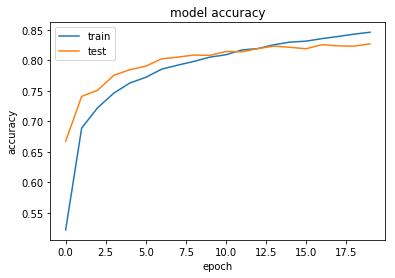

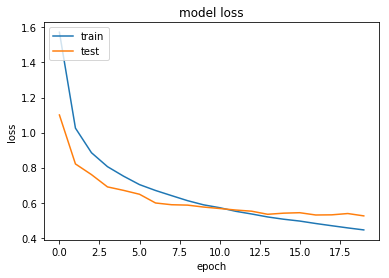

Test score: 0.524972629702
Test accuracy: 0.827286356851


In [35]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

In [36]:
############ This part is for HeelHeight ###############
# 1in...1.3.4in, 
# 2in...2.3.4in, 
# Under.1in,
# Flat,
# 4in...4.3.4in,
# 3in...3.3.4in,
# 5in...over

# init some variables
feature = 'HeelHeight'
num_classes = 7
epochs = 20

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

x_train shape: (23974, 50, 50, 1)
23974 train samples
5994 test samples
Train on 23974 samples, validate on 5994 samples
Epoch 1/20
23974/23974 [==============================] - 30s - loss: 1.4790 - acc: 0.4403 - val_loss: 1.1566 - val_acc: 0.5706
Epoch 2/20
23974/23974 [==============================] - 31s - loss: 1.1563 - acc: 0.5642 - val_loss: 1.0461 - val_acc: 0.6104
Epoch 3/20
23974/23974 [==============================] - 30s - loss: 1.0568 - acc: 0.5993 - val_loss: 0.9609 - val_acc: 0.6393
Epoch 4/20
23974/23974 [==============================] - 31s - loss: 0.9914 - acc: 0.6253 - val_loss: 0.8945 - val_acc: 0.6583
Epoch 5/20
23974/23974 [==============================] - 30s - loss: 0.9308 - acc: 0.6457 - val_loss: 0.8702 - val_acc: 0.6593
Epoch 6/20
23974/23974 [==============================] - 29s - loss: 0.8935 - acc: 0.6583 - val_loss: 0.8365 - val_acc: 0.6772
Epoch 7/20
23974/23974 [==============================] - 31s - loss: 0.8573 - acc: 0.6696 - val_loss: 0.7998 -

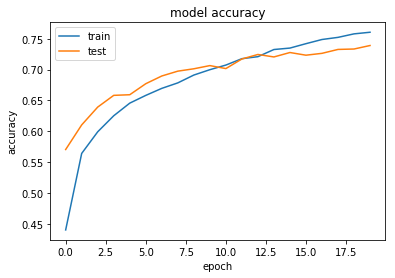

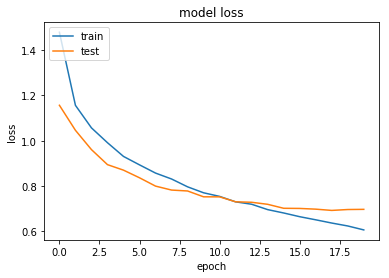

Test score: 0.697191866708
Test accuracy: 0.739072405739


In [37]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

In [38]:
############ This part is for Category ###############
# Shoes
# Boots
# Sandals
# Slippers

# init some variables
feature = 'Category'
num_classes = 4
epochs = 20

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

x_train shape: (40019, 50, 50, 1)
40019 train samples
10005 test samples
Train on 40019 samples, validate on 10005 samples
Epoch 1/20
40019/40019 [==============================] - 50s - loss: 0.5948 - acc: 0.7927 - val_loss: 0.3676 - val_acc: 0.8765
Epoch 2/20
40019/40019 [==============================] - 50s - loss: 0.3632 - acc: 0.8791 - val_loss: 0.2932 - val_acc: 0.9003
Epoch 3/20
40019/40019 [==============================] - 50s - loss: 0.3103 - acc: 0.8972 - val_loss: 0.2842 - val_acc: 0.9019
Epoch 4/20
40019/40019 [==============================] - 50s - loss: 0.2792 - acc: 0.9059 - val_loss: 0.2594 - val_acc: 0.9110
Epoch 5/20
40019/40019 [==============================] - 49s - loss: 0.2567 - acc: 0.9138 - val_loss: 0.2513 - val_acc: 0.9089
Epoch 6/20
40019/40019 [==============================] - 49s - loss: 0.2363 - acc: 0.9192 - val_loss: 0.2308 - val_acc: 0.9205
Epoch 7/20
40019/40019 [==============================] - 50s - loss: 0.2218 - acc: 0.9237 - val_loss: 0.2372

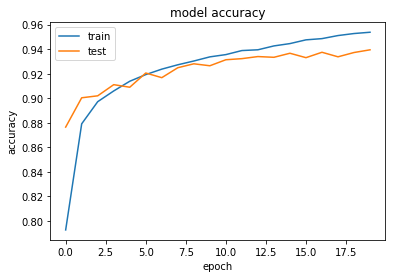

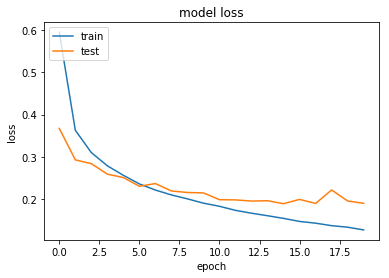

Test score: 0.190476707802
Test accuracy: 0.939430284881


In [39]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

In [47]:
def test_one(num, model, testImagePath):
#     test_model = get_model(num_classes)

#     # load weights
#     test_model.load_weights(modelPath)
#     # Compile model (required to make predictions)
#     test_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    # this block is for a example classification
    numArr = Image.open(testImagePath)
    numArr = numArr.resize((img_rows,img_cols))
    numArr = numArr.convert('L')
    #plt.imshow(numArr)

    xArr=[]
    xArr.append(numArr)

    numArr1 = np.array([np.array(tt).flatten() for tt in xArr])
    numArr1 = numArr1.astype(float)
    numArr1 /= 255
    numArr1 = numArr1.reshape(numArr1.shape[0], img_rows, img_cols, 1)

    somePredict = model.predict_classes(numArr1, verbose = 0)
    somePredict = somePredict.tolist()
    endList = [0] * num
    endList[somePredict[0]] = 1 
    return endList

def test_all(cat, heel, sub, gen, testImagePath):
    category = test_one(4, cat, testImagePath)
    heelHeight = test_one(7, heel, testImagePath)
    subCategory = test_one(21, sub, testImagePath)
    gender = test_one(4, gen, testImagePath)
    result = gender + category + heelHeight + subCategory
    return result

In [43]:
cat = get_model(4)
cat.load_weights(dir_path + 'models/Category.best.hdf5')
cat.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

heel = get_model(7)
heel.load_weights(dir_path + 'models/HeelHeight.best.hdf5')
heel.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

sub = get_model(21)
sub.load_weights(dir_path + 'models/SubCategory.best.hdf5')
sub.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

gen = get_model(4)
gen.load_weights(dir_path + 'models/Gender.best.hdf5')
gen.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [44]:
# this block for 100 survey test
survey_resize_list = os.listdir(dir_path + 'survey')
survey_resize_list = survey_resize_list[1:]
survey_result = np.zeros((len(survey_resize_list),36))
count = 0

for item in survey_resize_list:
    result = test_all(cat, heel, sub, gen, dir_path + 'survey/' + item)
    survey_result[count] = result
    count += 1

print(survey_result)

[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]]


[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Gender.Men
Category.Shoes
HeelHeight.Flat
SubCategory.Sneakers.and.Athletic.Shoes


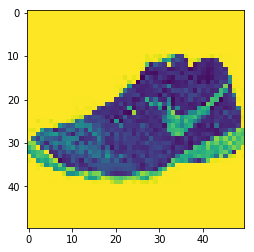

In [46]:
# this block for one image test
result = test_all(cat, heel, sub, gen, 'testImg1.jpg')
print(result)
# get all needed headers 
df = pd.read_csv('meta-data-bin.csv')
df1 = df.filter(regex='Category|HeelHeight|Gender')
headerList = df1.columns.values.tolist()
headerList = headerList[32:] + headerList[0:4] + headerList[25:32] + headerList[4:25]
#print(headerList[15:])
#print the classifications of the image
for index, value in enumerate(result):
    if value == 1:
        print(headerList[index])

In [48]:

# coding: utf-8

# In[1]:


# import numpy as np
# import scipy as sp
# import pandas as pd


df = pd.read_csv('adult-test_titled.csv')
meta = pd.read_csv('meta-data-bin.csv')


# In[2]:


df.count()


# In[3]:


meta.count()


# In[4]:


df.describe()


# In[5]:


meta.describe()


# In[6]:


df.head(10)


# In[7]:


meta.head(10)


# In[8]:


len(meta.columns)
#too many columns we do not need all of them so we are going to select part of them as our features.


# In[9]:


df.axes


# In[10]:


meta.axes


# In[11]:


labels = meta.axes[1].tolist()
#turn the meta data file to our label list
labels.pop(0) # we don't want the first one "CID"
#print(len(labels))


# In[12]:


SubCategory = list()
Category = list()
HeelHeight = list()
Closure = list()
Gender = list()
Material = list()
ToeStyle = list()
# we don't want the insole column
for label in labels:    
    shortLabel = label[label.find(".")+1:]   
    #print(shortLabel)
    if "SubCategory" in label:
       SubCategory.append(shortLabel)
    elif  "Category" in label:
       Category.append(shortLabel)
    elif  "HeelHeight" in label:
       HeelHeight.append(shortLabel)
    elif  "Closure" in label:
       Closure.append(shortLabel)
    elif  "Gender" in label:
       Gender.append(shortLabel)
    elif  "Material" in label:
       Material.append(shortLabel)
    elif  "ToeStyle" in label:
       ToeStyle.append(shortLabel) 


# In[18]:


Gender


# In[23]:


#build user profiles 
#for user 2
customer_profile = np.zeros((len(df),36))
#print (customer_profile[1])


# In[56]:


for i in range(len(Gender)): 
    print(str(i) + " " + Gender[i])


# In[57]:


for i in range(len(Category)): 
    print(str(i + len(Gender)) + " " + Category[i])


# In[58]:


for i in range(len(HeelHeight)): 
    print(str(i + len(Gender) + len(Category)) + " " + HeelHeight[i])


# In[81]:


for i in range(len(SubCategory)): 
    print(str(i + len(Gender) + len(Category) + len(HeelHeight)) + " " + SubCategory[i])


# In[127]:


for i in range(len(df)):
# Gender
    if "Female" in df.iloc[i,9]:
        customer_profile[i][1]=1
        if "Child" in df.iloc[i,7]:
            customer_profile[i][8]=1
            customer_profile[i][10]=1
            customer_profile[i][11]=1
        elif "Never-married" in df.iloc[i,5] or "Divorced" in df.iloc[i,5] or "Separated" in df.iloc[i,5]:
            customer_profile[i][9]=1
            customer_profile[i][12]=1
            customer_profile[i][13]=1
            customer_profile[i][14]=1
        if int(df.iloc[i,0]) > 50:
            #'Loafers'
            customer_profile[i][20]=1
            # shoe Flats
            customer_profile[i][25]=1   
            #'Slipper.Heels'
            customer_profile[i][27]=1
            #'Slipper Boot'
            customer_profile[i][19]=1
            # Slipper.Flats
            customer_profile[i][21]=1
            # low heel height
            customer_profile[i][8]=0
            customer_profile[i][10]=1
            customer_profile[i][11]=1            
            customer_profile[i][9]=0
            customer_profile[i][12]=0
            customer_profile[i][13]=0
            customer_profile[i][14]=0
        elif int(df.iloc[i,0]) >= 18: #age from 18 to 50
            #'Heels'
            customer_profile[i][28]=1   
            #sandal 'Heel'
            customer_profile[i][17]=1 
            #'Knee.High' 
            customer_profile[i][31]=1 
            # 'Ankle' 
            customer_profile[i][18]=1 
            # mid heel height
            customer_profile[i][9]=1            
            customer_profile[i][13]=1            
            if int(df.iloc[i,0]) <= 35:  #age from 18 to 35
                #'Over.the.Knee'
                customer_profile[i][35]=1
                #Flat sandals                 
                customer_profile[i][23]=1
                #Heel sandals                 
                customer_profile[i][17]=1
                #high heel height
                customer_profile[i][12]=1
                customer_profile[i][14]=1
            else:   #age from 35 to 50
                #24 Clogs.and.Mules
                customer_profile[i][24]=1
        elif int(df.iloc[i,0]) > 12:   #age from 12 to 18
             #Slipper.Flats
            customer_profile[i][21]=1  
            #'Sneakers.and.Athletic.Shoes'
            customer_profile[i][26]=1
            #flat sandals
            customer_profile[i][23]=1
            # low heel height
            customer_profile[i][8]=1
            customer_profile[i][10]=1
            customer_profile[i][11]=1
            customer_profile[i][9]=0
            customer_profile[i][12]=0
            customer_profile[i][13]=0
            customer_profile[i][14]=0
    elif "Male" in df.iloc[i,9]:
        customer_profile[i][0]=1 
         # very low heel height       
        customer_profile[i][10]=1
        customer_profile[i][11]=1
        #then shoes based on ages
        if int(df.iloc[i,0]) < 30:
            #'Sneakers.and.Athletic.Shoes'
            customer_profile[i][26]=1
            #29 Athletic sandals
            customer_profile[i][29]=1
        elif int(df.iloc[i,0]) < 40:
            #22 Boat.Shoes
            customer_profile[i][22]=1
            #20 Loafers
            customer_profile[i][20]=1
        elif int(df.iloc[i,0]) < 50:  
            #15 Oxfords
            customer_profile[i][15]=1
            #18 Ankle
            customer_profile[i][18]=1
        else:
            #'Slipper Boot'
            customer_profile[i][19]=1
            # Slipper.Flats
            customer_profile[i][21]=1
    #boys girls?
    #following is based on jobs
    if "Machine" in df.iloc[i,6] or "Tech" in df.iloc[i,6] or "Prof" in df.iloc[i,6] or "Transport" in df.iloc[i,6] or "managerial" in df.iloc[i,6]:
        #Shoes
        customer_profile[i][4]=1
    if "fishing" in df.iloc[1,6] or "Armed" in df.iloc[i,6] or "cleaners" in df.iloc[i,6]:
        #Boots
        customer_profile[i][5]=1
    if "service" in df.iloc[i,6]: 
        #Sandals
        customer_profile[i][6]=1
    if "Craft" in df.iloc[i,6]:
        #Slippers
        customer_profile[i][7]=1



# In[147]:





# In[128]:


feature_vector = list()
feature_vector = Gender + Category + HeelHeight + SubCategory
#print(feature_vector)


# In[129]:





# In[138]:


# enter user number here
user = 11005
print()
print("user's data")
print()
print (df.iloc[user,:])
print()
print("user profile we built for above user")
print()
for i in range(36):   
    print("{0:28} {1}".format(feature_vector[i].replace("."," ") ,int(customer_profile[user][i])))
    #print(str(i) + " " + feature_vector[i] + " " + str(int(customer_profile[11001][i])))


# In[153]:


weight_scale= np.ones((1,36))
k = 5
for j in range(4):
    weight_scale[0][j] = k
weighted_customer_profile = weight_scale[0]*customer_profile[user]
print()
print("we added weights to gender, below is new user profile: ")
print(weighted_customer_profile)


# In[ ]:






0 Men
1 Women
2 Boys
3 Girls
4 Shoes
5 Boots
6 Sandals
7 Slippers
8 1in...1.3.4in
9 2in...2.3.4in
10 Under.1in
11 Flat
12 4in...4.3.4in
13 3in...3.3.4in
14 5in...over
15 Oxfords
16 Mid.Calf
17 Heel
18 Ankle
19 Boot
20 Loafers
21 Slipper.Flats
22 Boat.Shoes
23 Flat
24 Clogs.and.Mules
25 Flats
26 Sneakers.and.Athletic.Shoes
27 Slipper.Heels
28 Heels
29 Athletic
30 Prewalker
31 Knee.High
32 Prewalker.Boots
33 Crib.Shoes
34 Firstwalker
35 Over.the.Knee

user's data

age                               29
workclass                    Private
fnlwgt                        153475
eudcation                       11th
education_num                      7
marital_status              Divorced
occupation         Machine-op-inspct
relationship               Unmarried
race                           White
gender                        Female
capital_gain                       0
capital_loss                       0
hours_per_week                    40
native_country         United-States
income_bracket 

['1101071509_640.jpg/0.130082327598', '1110972412_640.jpg/0.130082327598', '1127370369_640.jpg/0.130082327598', '1127370759_640.jpg/0.130082327598', '1149643428_640.jpg/0.130082327598', '1149643429_640.jpg/0.130082327598', '1160640122_640.jpg/0.130082327598', '1012117545_640.jpg/0.161150815898', '1030609429_640.jpg/0.161150815898', '1035647559_640.jpg/0.161150815898']
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1
Gender.Women
Category.Boots
HeelHeight.3in...3.3.4in
SubCategory.Flat
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
2
Gender.Women
Category.Shoes
HeelHeight.4in...4.3.4in
SubCategory.Heels
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3
Gender.Women
Category.Shoes
HeelHeight.5in...over
SubCategory.Flat
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

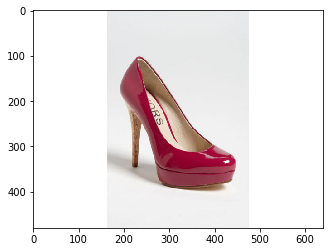

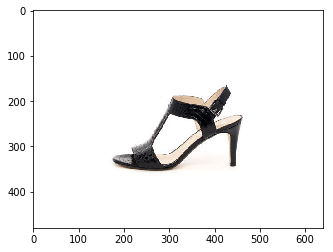

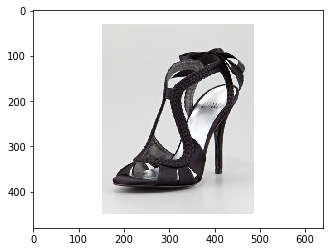

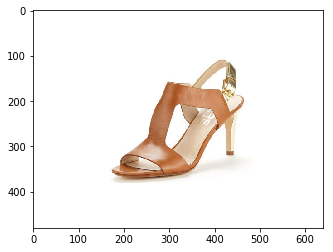

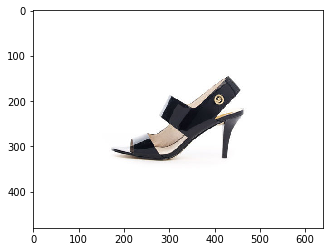

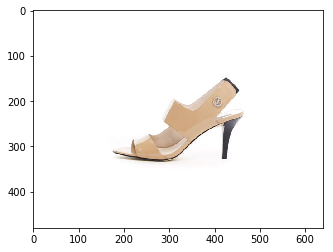

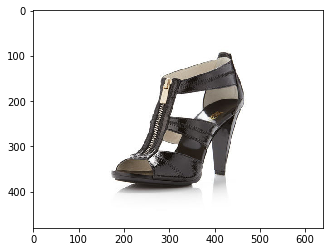

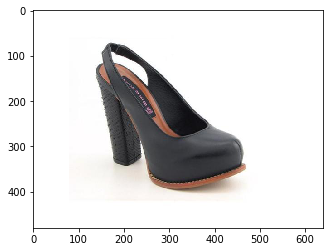

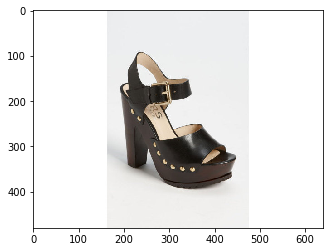

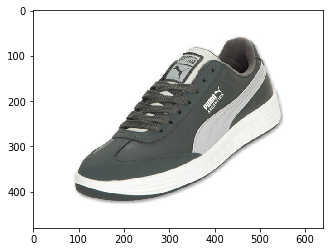

In [49]:
#from scipy import spatial

def takeValue(val):
    return float(val.split('/')[1])

# get array of list and distance
tempList = []
cc = 0

for item in survey_result:
    weighted_shoe_profile = weight_scale[0]*item
    tempList.append(survey_resize_list[cc] + '/' + str(spatial.distance.cosine(weighted_customer_profile,weighted_shoe_profile)))
    cc += 1

# get 10 most likely 
tempList.sort(key=takeValue)
top_number = 10
print(tempList[0:top_number])
ccc =1
for item in tempList[0:top_number]:
    numArr = Image.open(dir_path + 'survey/' + item.split('/')[0])


    plt.figure()
    plt.imshow(numArr)
    
    # get all needed headers 
    result = test_all(cat, heel, sub, gen, dir_path + 'survey/' + item.split('/')[0])
    print(result)
    df = pd.read_csv('meta-data-bin.csv')
    df1 = df.filter(regex='Category|HeelHeight|Gender')
    headerList = df1.columns.values.tolist()
    headerList = headerList[32:] + headerList[0:4] + headerList[25:32] + headerList[4:25]

    # print the classifications of the image
    print(ccc)
    ccc+=1
    for index, value in enumerate(result):
        if value == 1:
            print(headerList[index])
    
#print(customer_profile[user])
# ##


# the smaller the better
#print(spatial.distance.jaccard([0, 1, 0, 1, 0, 1], [0, 1, 0, 1, 0, 1]))